### This notebook is for analyzing the molecular gas in SDSS1531

1. Quantify Offset between YSCs and Molecular Gas
2. Dust Mass Upper Limit
3. Gas Depletion Timescale
4. Lim (2008) Free Fall
5. Could ram pressure explain the offset between the young stars and the molecular gas? 

In [1]:
#set path to beads folder
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [2]:
#system
import sys

#astropy
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const
from astropy.wcs import WCS
from astropy.cosmology import LambdaCDM
from astropy.coordinates import Galactic

#matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm

#seaborn
import seaborn as sns

#numpy
import numpy as np

from spectral_cube import SpectralCube


#pv extractor
from pvextractor import extract_pv_slice
from pvextractor import PathFromCenter

import importlib


In [3]:
#import modules
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [17]:
#uncomment if need to reload module
importlib.reload(sf)

<module 'science_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/science_functions.py'>

In [5]:
#About
sf.sdss1531_dict

{'name': 'SDSS J1531+3414',
 'ra': 232.7936938,
 'dec': 34.2404172,
 'radius': 2.5,
 'z': 0.335,
 'cz': 100430.47}

In [6]:
z = sf.sdss1531_dict['z'] # best redshift for SDSS 1531
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

At a redshift of 0.335, we have 4.7671 kpc / arcsec


In [7]:
co32_file = path_to_beads + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'
fig_path = path_to_beads + 'Figures/paper/'

In [8]:
pf.styleplots()

### 1. Quantify Offset between YSCs and Molecular Gas

In [9]:
#load hst data and ysc
hst_hdr, hst_wcs, hst_hdu = sf.load_HST_data(path_to_beads)
ysc_coords = sf.ysc_load(path_to_beads)

ysc_color, hst_cont_color = 'purple', 'k'

Plot the slices where the gas looks most associated with the beads

Cube is a Stokes cube, returning spectral cube for I component
The following kwargs were not used by contour: 'aspect'
The following kwargs were not used by contour: 'rasterized'
The following kwargs were not used by contour: 'aspect'
The following kwargs were not used by contour: 'rasterized'
The following kwargs were not used by contour: 'aspect'
The following kwargs were not used by contour: 'rasterized'


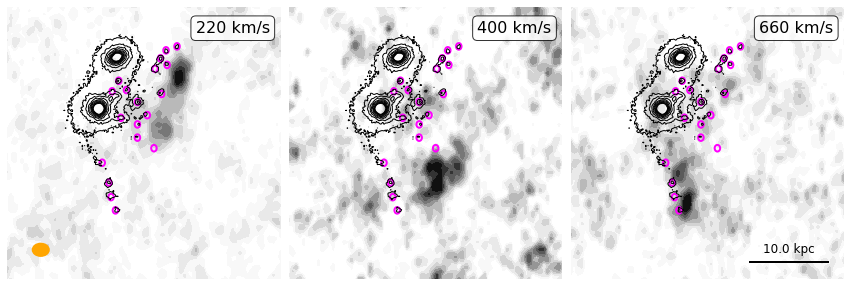

In [83]:
#data 
alma_cube = SpectralCube.read(co32_file)
hdr = alma_cube.header
velocities = [220, 400, 660]

#plot specifics
plot_width, plot_height = 5, 5
nrows, ncols = 1, 3
clims=[[0, 0.0019], [0, 0.0013], [0, 0.0013]]
zoom_moment_coords = [sf.sdss1531_dict['ra']+ 2e-4, sf.sdss1531_dict['dec']-4e-4, sf.sdss1531_dict['radius']*1.5 * u.arcsec]
ysc_color = 'magenta'

#draw
fig = plt.figure(figsize=(plot_width*ncols, plot_height*nrows))
gs1 = GridSpec(nrows, ncols)
gs1.update(wspace=0.03, hspace=0.01)

axs = []

for id_subplot in range(nrows*ncols):

    velocity = velocities[id_subplot]
    clim = clims[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(hdr), slices=('x', 'y', 0))

    ax = pf.ax_fits_map(alma_cube.hdu, cmap=cm.Greys, vmin=clim[0], vmax=clim[1],
                     coords=zoom_moment_coords, ax=ax, vel=velocity, cbar=False, 
                     contour=True)

    #HST Contours: uncomment below lines if not in rush
    pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color=hst_cont_color, lw=1)

    #YSC Overlay
    pf.overlay(ax, None, 1, None, None, clusters=True, cont_color=ysc_color, 
                ysc_coords=ysc_coords)
    ax.axis('off')

    props = dict(boxstyle='round', facecolor='w', alpha=0.8)
    ax.text(170, 170, '{} km/s'.format(velocity), color='k',
             bbox=props, fontsize=16)

    axs.append(ax)

#add beam and scale
pf.add_scale(ax, 10 * u.kpc, hdr, cosmo, color='k', ytxt=0.05, lw=2)
beam = pf.add_beam(axs[0], hdr, 115, 95, bcolor='orange', fc='orange')


In [10]:
#drew line between beads and gas in DS9 and put points below
pointa_north, pointb_north = np.array((232.7937293,34.240680)), np.array((232.7935844,34.2405989))
pointa_south, pointb_south = np.array((232.7942073,34.2397454)),np.array((232.7941626,34.2398151))

In [11]:
north_distance = np.linalg.norm(pointa_north - pointb_north) * u.deg
south_distance = np.linalg.norm(pointa_south - pointb_south) * u.deg

In [12]:
print("Beads in North offset by: {} \n".format(north_distance.to(u.arcsec)),
        "Beads in south offset by: {}".format(south_distance.to(u.arcsec)))

Beads in North offset by: 0.5977866937510583 arcsec 
 Beads in south offset by: 0.29808739126110956 arcsec


In [13]:
north_physical_distance = north_distance * kpc_per_arcsec
south_physical_distance = south_distance * kpc_per_arcsec
print("Beads in North offset by: {} \n".format(north_physical_distance.to(u.kpc)),
        "Beads in south offset by: {}".format(south_physical_distance.to(u.kpc)))

Beads in North offset by: 2.8497109817383963 kpc 
 Beads in south offset by: 1.4210134171174502 kpc


In [14]:
# gal_337_point = np.array((232.76145416696866, 34.24256527794732))
# bcg_point = np.array((sf.sdss1531_dict['ra'], sf.sdss1531_dict['dec']))

# distance_galaxies = np.linalg.norm(gal_337_point - bcg_point) * u.deg
# physical_distance_galaxies = distance_galaxies * kpc_per_arcsec
# print("Distance between BCG and z=0.3371 Galaxy is: {} \n".format(physical_distance_galaxies.to(u.kpc)))

### 2. Place Upper Limit on Dust Mass

Here, we use CARTA to define a region in the low resolution continuum data and obtain the STD and Npix within the region

In [15]:
low_res_cont_cube = SpectralCube.read(path_to_beads + 'Analysis/almaBeads/alma_products/649/member.uid___A001_X2fe_X649.calibrated_final_cont.pbcor.fits')

std = 1.35e-5 * u.Jy/u.beam
npix = 1.09e3
intensity = sf.jybeam_to_jy(std, npix, low_res_cont_cube)

print("2sigma upper limit on flux density: {:.2e}".format(2*intensity))

2sigma upper limit on flux density: 4.87e-04 Jy


Cube is a Stokes cube, returning spectral cube for I component


In [20]:
nu = low_res_cont_cube.header['CRVAL3'] * u.Hz
dl = cosmo.luminosity_distance(z)
S_nu = 2*intensity
t_d = 25 * u.K

dust_mass = sf.dust_mass(S_nu, nu, dl, t_d)

print("Dust mass upper limit: {:.2e}".format(dust_mass))

Dust mass upper limit: 3.70e+08 solMass


### 3. Gas Depletion Timescale

In [21]:
sfr_min, sfr_max = 1 * u.solMass/u.yr, 10 * u.solMass/u.yr
mh2 = 3.5e10 * u.solMass
tdep_min, tdep_max = (mh2/sfr_max).to(u.Gyr), (mh2/sfr_min).to(u.Gyr)


print(f"Minimum / Maximum depletion time: {tdep_min, tdep_max}")

Minimum / Maximum depletion time: (<Quantity 3.5 Gyr>, <Quantity 35. Gyr>)


### 4. Lim (2008): Does Freefall describe the motion of the molecular gas?

In [22]:
#Functions from Lim (2008)

def rho(mass, a, r):
    #equation 1
    top = mass * a
    bottom = 2 * np.pi * np.power((r + a), 3)
    return top/bottom

def scale_length(r_half):
    #equation 2
    factor = 2 + np.sqrt(2)
    return r_half/factor

def potential(a, r, mass):
    #equation 3
    top = -1 * const.G * mass
    bottom = r + a
    return top/bottom

def v_freefalll(mass, r, a, r0=10*u.kpc, v0=0):
    #equation 4
    term1 = np.power(v0,2)/2
    term2 = potential(a, r0, mass)
    term3 = potential(a, r, mass)
    return np.sqrt(2 * (term1 + term2 - term3))


In [23]:
#Obtain PV Diagram 

#define path using ds9 region
g = Galactic(54.6827002 * u.deg, 55.1567183 * u.deg)
total_region_path = PathFromCenter(center=g, length=10.320 * u.arcsec, angle=65.491813 * u.deg,  width=3.163 * u.arcsec)

#print pixel coordinates of path
cube = SpectralCube.read(co32_file)
m0_name, m1_name, m2_name = co32_file[:-5]+ '_M0.fits', co32_file[:-5] + '_M1.fits', co32_file[:-5] + '_M2.fits'

total_region_slice = extract_pv_slice(cube, total_region_path)  
hdu2, hdr2 = total_region_slice, total_region_slice.header

Cube is a Stokes cube, returning spectral cube for I component


In [47]:
i = 60 * u.deg
np.sin(i.to(u.rad))

<Quantity 0.8660254>

In [55]:
def freefall_velocity(height, hdr, cosmology, num_intervals=25, v0=600*(u.km/u.s), radius=25*u.kpc,
                        radius_0=0*u.kpc, i=72*u.deg):
    """ 
    calculates velocity and distance travelend given a height

    estimated stellar mass using http://skyserver.sdss.org/dr16/en/tools/explore/DisplayResults.aspx?name=stellarMassPassivePortQuery&id=1237661851485929746&spec=1525703272785012736&apid=&fieldId=0x112d0ee581df0000&ra=232.794161402854&dec=34.2402901374315&plateId=1525594421133862912&mangaid= 
    estimated halo mass from Sharon (2014)
    """
    halo_mass = 1.09e13 * u.solMass #estimate within 25kpc using figure 3
    stellar_mass = np.power(10, 11.58) * u.solMass * 2 #stellar mass of one elliptical * 2

    r_effective = radius/2
    a = scale_length(r_effective) #guess half mass radius is half of the radius

    radial_distances = np.linspace(0, radius.value, num_intervals) * u.kpc
    radial_vels = v_freefalll(halo_mass, radial_distances * np.sin(i.to(u.rad)), a, r0=height, 
                                v0=v0).to(u.km/u.s)- v0

    #make all negative radial velocities 0
    idr = np.where((radial_vels > 0) & (~np.isnan(radial_vels)))
    radial_vels = radial_vels[idr] * np.cos(i)
    radial_distances = radial_distances[idr] + radius_0


    #convert velocity and distance to pixels so can plot
    wcs = WCS(hdr)
    pixel_vels = [int(wcs.wcs_world2pix(0, 0, radial_vel * 1000, 0)[2]) for radial_vel in radial_vels]
    pixel_dist = radial_distances/pf.distance(hdr['CDELT2'] * u.deg, hdr, cosmology)

    return pixel_vels, pixel_dist

In [56]:
pixel_vels_15, pixel_distances_15 = freefall_velocity(16 * u.kpc, cube.header, cosmo, radius_0=12*u.kpc)
pixel_vels_25, pixel_distances_25 = freefall_velocity(25 * u.kpc, cube.header, cosmo, radius_0=12*u.kpc)
pixel_vels_35, pixel_distances_35 = freefall_velocity(55 * u.kpc, cube.header, cosmo, radius_0=12*u.kpc)

invalid value encountered in sqrt


The following kwargs were not used by contour: 'rasterized'


<WCSAxesSubplot:xlabel='Position ["]', ylabel='$v \\cos i$ [km/s]'>

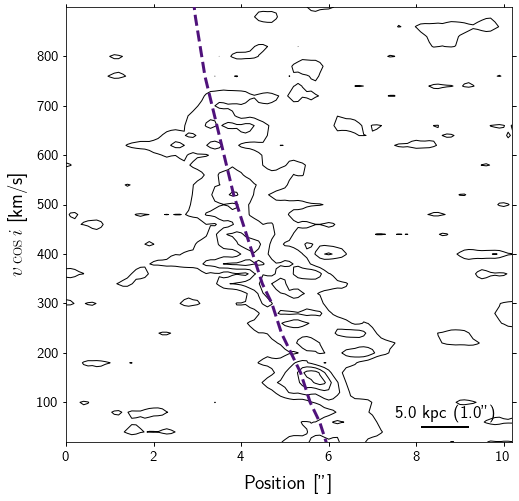

In [57]:
fig = plt.figure(figsize=(8,8))


ax2 = fig.add_subplot(111, projection=WCS(hdr2))
pf.overlay(ax2, hdu2, 1, vmin=1e-4, vmax=1e-3, contours=True, cont_color='k', lw=1)
#ax2.set_ylim(17, 40)
ycoord = ax2.coords[1]
ycoord.set_ticks(spacing=100 * (u.km/u.s))
ycoord.set_format_unit(u.km / u.s)
ycoord.set_axislabel(r'$v \cos i$ [km/s]', fontsize=20)

xcoord = ax2.coords[0]
xcoord.set_ticks(number=5)
xcoord.set_major_formatter('x')
xcoord.set_format_unit(u.arcsec)
xcoord.set_axislabel('Position ["]', fontsize=20)
ax2.set_ylim(35)

#using sharon mass
# ax2.plot(pixel_dist, pixel_vels, '-', color='g')

colors = sns.color_palette('magma_r',3)
#ax2.plot(pixel_distances_25, pixel_vels_25, '--', color=colors[0], lw=3, label='25 kpc')
#ax2.plot(pixel_distances_35, pixel_vels_35, '--', color=colors[1], lw=3, label='10 kpc')
ax2.plot(pixel_distances_15, pixel_vels_15, '--', color=colors[2], lw=3, label='17 kpc')

pf.add_scale(ax2, 5 * u.kpc, hdr2, cosmo, color='k', hdr_cdelt='CDELT1', xtf=0.9,ytf=0.015, ytxt=0.03, lw=2, fsize=18)


# fig.savefig(''.join((fig_path, 'alma_freefall.pdf')))

### 5. Could ram pressure explain the offset between the young stars and the molecular gas? 



In [13]:
#load cube
co32_file = path_to_beads + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'
cube = SpectralCube.read(co32_file)
rms =  (0.204 *(u.mJy/u.beam)).to(u.Jy/u.beam)  

Cube is a Stokes cube, returning spectral cube for I component


How much gas can ram pressure strip?

In [58]:
G = const.G

#equations from Domainko (2006) https://www.aanda.org/articles/aa/pdf/2006/24/aa3921-05.pdf
def mass_stripped(M_gas, x):
    """
    This function calculates the stripped gas mass due to ram pressure,
    given the total gas mass and a scaling factor x.
    Domainko (2006) eqn 7
    
    Parameters:
    - M_gas (float): gas  mass of the BCG in solar masses.
    - x (float): Scaling factor that determines the amount of stripping.
    
    Returns:
    - float: The stripped mass in solar masses.
    """
    M_strip = (x + 1) * np.exp(-x) * M_gas
    return M_strip

def mass_kept(M_gas, x):
    """
    This function calculates the stripped gas mass due to ram pressure,
    given the total gas mass and a scaling factor x. Domainko (2006) eqn 6
    
    Parameters:
    - M_gas (float): gas  mass of the BCG in solar masses.
    - x (float): Scaling factor that determines the amount of stripping.
    
    Returns:
    - float: The stripped mass in solar masses.
    """
    M_kept = M_gas * (1 - (x+1)*np.exp(-x))
    return M_kept
def mstrip_x(M_tot, M_gas, R_0, v_gal, rho_ICM):
    """
    This function calculates the scaling factor x, which determines the amount
    of stripping due to ram pressure.Domainko (2006) eqn 4
    
    Parameters:
    - M_tot (float): Total mass of the BCG in solar masses.
    - R_0 (float): Petrosian radius in kpc.
    - v_gal (float): Relative velocity between the BCG and the ICM in km/s.
    - rho_ICM (float): Density of the ICM in g/cm^3.
    
    Returns:
    - float: The scaling factor x.
    """
    x = 0.5 * np.log(((G * M_tot * M_gas) / (2 * np.pi * R_0**4 * v_gal**2 * rho_ICM)).cgs)
    return x.value


In [59]:
M_total = 1.09e13 * u.solMass #estimate within 25kpc using figure 3
M_star = np.power(10, 11.58) * u.solMass * 2 #stellar mass of one elliptical * 2

M_gas = 1e11 * u.solMass# total gas mass withi 30 kpc according to gas density profile

petrosian_rad = 30 * u.kpc #tremblay14
r_effective = petrosian_rad/2
R_0 = petrosian_rad#scale_length(r_effective) #guess half mass radius is half of the radius


v_gal = 300 * u.km/u.s  # Relative velocity between the BCG and the ICM taken to be relative velocity between galaxies; tremblay 14
rho_ICM = 6 * 10**(-26) * u.g/(u.cm)**3  # ICM density within 30 kpc

x = mstrip_x(M_total, M_gas, R_0, v_gal, rho_ICM)
M_strip = mass_stripped(M_gas, x)

print(f"The mass stripped is {M_strip/10**11} x 10^11 solar masses")
print(f"r_strip is {x*R_0}")


The mass stripped is 0.6542897281732929 solMass x 10^11 solar masses
r_strip is 36.693416286881735 kpc


How long would it take ram pressure to separate the stars and gas?

In [64]:
#surface area of molecular gas
major_axis = 2.320 * u.arcsec * kpc_per_arcsec
minor_axis = 1.421 * u.arcsec * kpc_per_arcsec

area_mol_gas = np.pi * major_axis * minor_axis

#acceleration due to ram pressure
F_ram = rho_ICM * v_gal**2 * area_mol_gas
mass_mol_gas = 3e10 * u.solMass
F_g = G * M_total * mass_mol_gas / (R_0**2)
accel_ram = (F_ram)/mass_mol_gas

print(f"acceleration due to ram pressure is {accel_ram.cgs}")

d_sep_min, d_sep_max = 1 * u.kpc, 3 * u.kpc
time_ram_min = np.sqrt((2*d_sep_min)/accel_ram)
time_ram_max = np.sqrt((2*d_sep_max)/accel_ram)

print(f"minimum time needed to separate gas from stars is {time_ram_min.to(u.Myr)}")
print(f"maximum time needed to separate gas from stars is {time_ram_max.to(u.Myr)}")

acceleration due to ram pressure is 2.0286576600967845e-09 cm / s2
minimum time needed to separate gas from stars is 55.26903995314663 Myr
maximum time needed to separate gas from stars is 95.72878528440418 Myr
